In [7]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.data.path.append(r"C:\Users\Christian\AppData\Roaming\nltk_data")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# get data

In [8]:
# Load the dataset
url = "https://raw.githubusercontent.com/AsukaaNao/datasets/refs/heads/main/cyberbullying_tweets.csv"
data = pd.read_csv(url)
data['tweet_text'] = data['tweet_text'].astype(str)
data['cyberbullying_type'] = data['cyberbullying_type'].astype(str)
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


# preprocessing

In [9]:
# Define stopwords and common slang dictionary
stop_words = set(stopwords.words('english'))

# Mapping for internet slang/abbreviations
slang_dict = {
    "idk": "i don't know",
    "wtd": "what to do",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "brb": "be right back",
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the fuck",
    "omw": "on my way",
    "fyi": "for your information",
    "imo": "in my opinion",
    "ikr": "i know, right",
    "nvm": "never mind",
    "ftw": "for the win",
    "thx": "thanks",
    "np": "no problem",
    "gtg": "got to go",
    "afk": "away from keyboard",
    "bff": "best friends forever",
    "wyd": "what are you doing",
    "hbu": "how about you",
    "ily": "i love you",
    "omfg": "oh my fucking god",
    "gg": "good game",
    "gr8": "great",
    "yolo": "you only live once",
    "tmi": "too much information",
    "stfu": "shut the fuck up",
    "btfo": "back the fuck off",
    "wtg": "way to go",
    "srsly": "seriously",
    "jk": "just kidding",
    "hbd": "happy birthday",
    "asap": "as soon as possible",
    "fml": "fuck my life",
    "ty": "thank you",
    "np": "no problem",
    "ikr": "i know, right",
    "idc": "i don't care",
    "ttfn": "ta ta for now",
    "dw": "don't worry",
    "rn": "right now"
}

# Function to clean and preprocess tweets
def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove hashtags but keep the text (e.g., #happy -> happy)
    tweet = re.sub(r'#', '', tweet)
    # Replace slang with their mapped meaning
    words = tweet.split()
    words = [slang_dict.get(word.lower(), word) for word in words]
    tweet = ' '.join(words)
    # Tokenize and remove stopwords while preserving sentence context
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # if len(tokens) == 0:
    #     return None
    
    # Rejoin tokens to form the cleaned sentence
    cleaned_tweet = ' '.join(tokens)
    return cleaned_tweet

# Apply preprocessing
data['tweet_text'] = data['tweet_text'].apply(preprocess_tweet)

# Display sample results
print(data[['tweet_text']].head())

                                          tweet_text
0        words katandandre , food crapilicious ! mkr
1  aussietv white ? MKR theblock ImACelebrityAU t...
2               classy whore ? red velvet cupcakes ?
3  meh . : P thanks heads , concerned another ang...
4  ISIS account pretending Kurdish account . Like...


In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

nltk.download('vader_lexicon')

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def preprocess_tweet(tweet):
    # Convert tweet to lowercase
    tweet = tweet.lower()
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove hashtags but keep the text (e.g., #happy -> happy)
    tweet = re.sub(r'#', '', tweet)
    
    # Replace slang with their mapped meaning
    words = tweet.split()
    words = [slang_dict.get(word, word) for word in words]
    tweet = ' '.join(words)
    
    # Tokenize and remove stopwords
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word not in stop_words]
    
    # Combine words into a cleaned tweet
    cleaned_tweet = ' '.join(tokens)
    
    # Sentiment analysis to detect bullying context
    sentiment = sia.polarity_scores(tweet)  # Get sentiment scores
    
    # If sentiment is negative, it's more likely to be bullying
    if sentiment['compound'] <= -0.3:  # You can adjust the threshold as needed
        # Add a flag indicating potential bullying
        cleaned_tweet += " [bullying]"
    
    return cleaned_tweet

# Apply preprocessing
data['tweet_text'] = data['tweet_text'].apply(preprocess_tweet)

# Display sample results
print(data[['tweet_text']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Christian\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                          tweet_text
0        words katandandre , food crapilicious ! mkr
1  aussietv white ? mkr theblock imacelebrityau t...
2    classy whore ? red velvet cupcakes ? [bullying]
3  meh . : p thanks heads , concerned another ang...
4  isis account pretending kurdish account . like...


In [11]:
encoding_map = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

# Apply the mapping to the 'cyberbullying_type' column
data['cyberbullying_type'] = data['cyberbullying_type'].map(encoding_map)

In [5]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to preprocess and tokenize tweets
def get_word_frequency(tweets):
    all_words = []
    for tweet in tweets:
        tokens = word_tokenize(tweet)
        filtered_tokens = [word.lower() for word in tokens if word.isalpha()]
        all_words.extend(filtered_tokens)
    return Counter(all_words)

# Initialize a dictionary to store word frequencies for each label
label_word_freq = {}

# Loop through each unique label in 'cyberbullying_type' and calculate word frequencies
for label in data['cyberbullying_type'].unique():
    label_tweets = data[data['cyberbullying_type'] == label]['tweet_text']
    label_word_freq[label] = get_word_frequency(label_tweets)

# Convert word frequency counters to DataFrames and sort them
label_word_freq_df = {}
for label, word_freq in label_word_freq.items():
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    label_word_freq_df[label] = word_freq_df

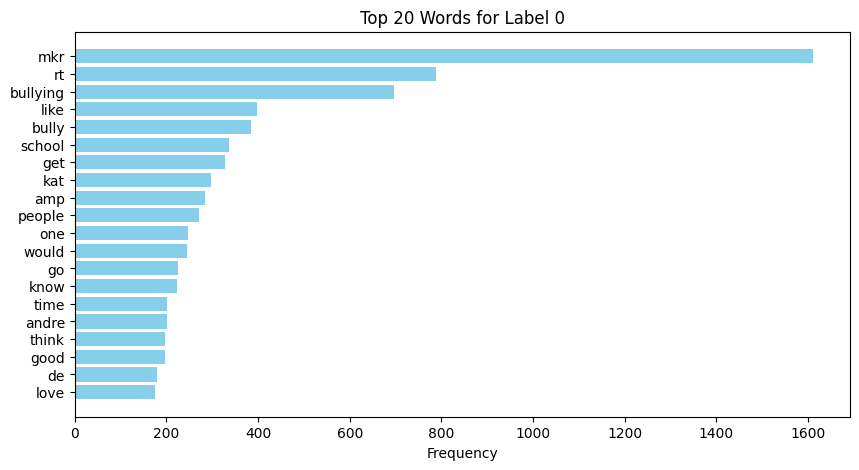

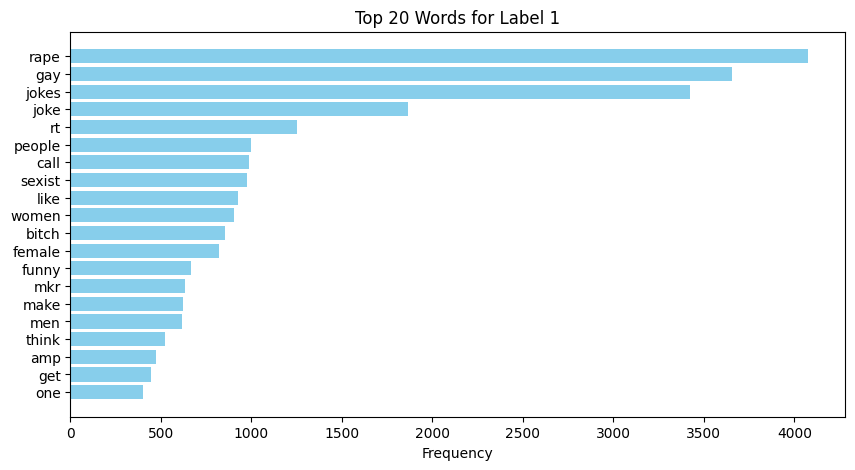

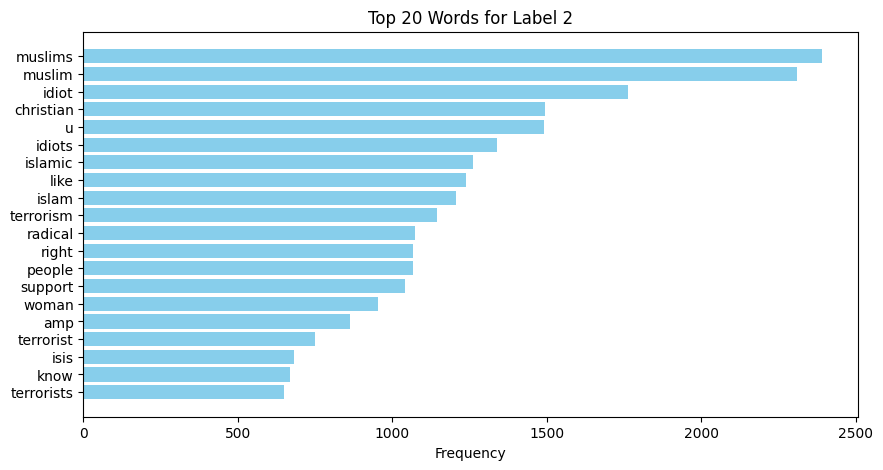

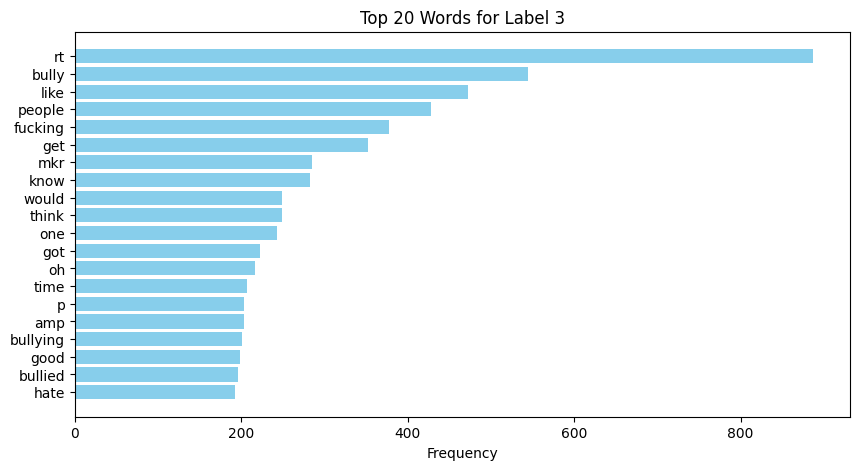

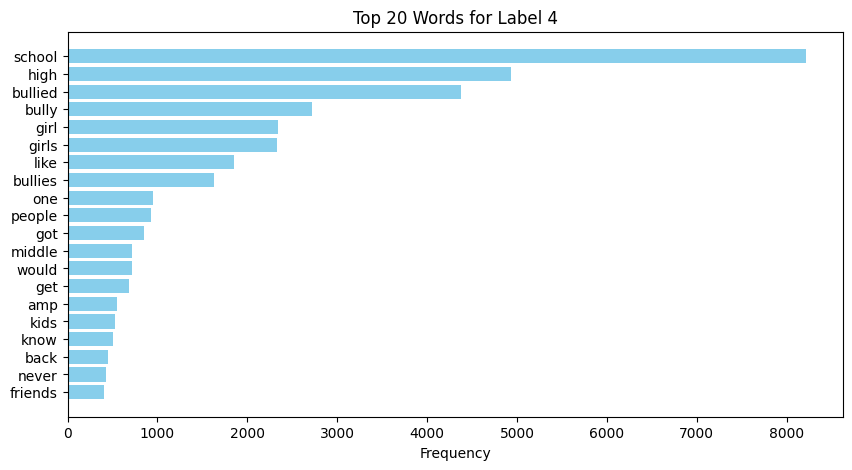

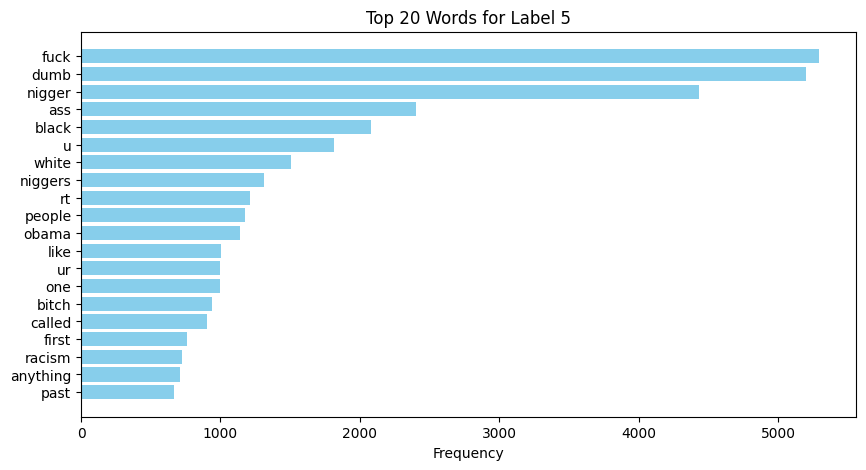

In [6]:
import matplotlib.pyplot as plt

# Display the top 20 words for each label as a separate bar chart
for label, word_freq_df in label_word_freq_df.items():
    # Select the top 20 words
    top_20_words = word_freq_df.head(20)
    
    # Create a bar chart
    plt.figure(figsize=(10, 5))
    plt.barh(top_20_words['Word'], top_20_words['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 20 Words for Label {label}')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest frequency at the top
    plt.show()


# modeling

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tokenize the cleaned tweets
tokenizer = Tokenizer(num_words=5000)  # Limit to the top 5000 most frequent words
tokenizer.fit_on_texts(data['tweet_text'])

# Convert tweets to sequences of integers
X = tokenizer.texts_to_sequences(data['tweet_text'])

# Pad sequences to ensure they have the same length
max_length = 100  # You can adjust this based on the average tweet length
X = pad_sequences(X, padding='post', maxlen=max_length)

# Define the target variable (encoded labels)
y = data['cyberbullying_type']

# Apply one-hot encoding for multi-class classification
y = to_categorical(y, num_classes=len(encoding_map))  # Convert labels to one-hot encoded format

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

labels = data['cyberbullying_type']

# Class weights for imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels.values
)
class_weights_dict = dict(zip(np.unique(labels), class_weights))

print(class_weights_dict)

# Calculate class weights to handle imbalanced classes
class_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}  # Adjust these weights based on the class distribution

# Build the model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(encoding_map), activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=11,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    # uncomment if wanna do early stopping
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {accuracy*100:.2f}%")

# Predict cyberbullying labels for the test set
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)  # Convert one-hot predictions to class labels

# Convert one-hot encoded labels back to class labels for the test set
y_test_labels = y_test.argmax(axis=1)

# Classification report
print(classification_report(y_test_labels, y_pred))

# # Create DataFrame to show predictions for test tweets
# df_results = pd.DataFrame({
#     'Tweet': data['tweet_text'].iloc[X_test.index],  # Retrieve original tweets based on indices
#     'Predicted Label': y_pred,
#     'Actual Label': y_test_labels
# })

# print(df_results.head(20))  # Display first 20 predictions


{0: 1.0004615061883784, 1: 0.9969480329445211, 2: 0.9938317912811536, 3: 1.0160637436618518, 4: 0.994577911244578, 5: 0.9984507808901729}


c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/11
1342/1342 - 228s - 170ms/step - accuracy: 0.7482 - loss: 0.5906 - val_accuracy: 0.8130 - val_loss: 0.4439
Epoch 2/11
1342/1342 - 228s - 170ms/step - accuracy: 0.8353 - loss: 0.4083 - val_accuracy: 0.8354 - val_loss: 0.4346
Epoch 3/11
1342/1342 - 250s - 187ms/step - accuracy: 0.8591 - loss: 0.3546 - val_accuracy: 0.8314 - val_loss: 0.4383
Epoch 4/11
1342/1342 - 285s - 213ms/step - accuracy: 0.8710 - loss: 0.3182 - val_accuracy: 0.8306 - val_loss: 0.4732
Epoch 5/11
1342/1342 - 219s - 163ms/step - accuracy: 0.8778 - loss: 0.2966 - val_accuracy: 0.8338 - val_loss: 0.4983
150/150 - 3s - 18ms/step - accuracy: 0.8354 - loss: 0.4346
Test accuracy: 83.54%
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
              precision    recall  f1-score   support

           0       0.72      0.44      0.54       787
           1       0.89      0.83      0.86       798
           2       0.96      0.95      0.95       784
           3       0.58      0.85      0.69       798
           4       0.

In [13]:
#save model
import pickle
model.save('saved_models/cyberbullying_model')

# Save the tokenizer to a file
with open('saved_models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_models/cyberbullying_model.

# try to read context

## using berd

In [8]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import create_optimizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import Dataset
import tensorflow as tf

# Split the dataset into train and test
X = data['tweet_text'].tolist()
y = data['cyberbullying_type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input text for BERT
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_encodings = encode_texts(X_train, tokenizer)
test_encodings = encode_texts(X_test, tokenizer)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(y_train, dtype=tf.int32)
test_labels = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Create TensorFlow datasets
train_dataset = Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(16)

test_dataset = Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

# Load BERT model
model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(encoding_map)
)

# Compile the model
batch_size = 16
num_train_steps = len(train_dataset) * 3  # Assuming 3 epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,  # Learning rate
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3,
    # callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict and evaluate
y_pred_logits = model.predict(test_dataset).logits
y_pred = tf.argmax(y_pred_logits, axis=1).numpy()

print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the model and tokenizer
model.save_pretrained('./bert_cyberbullying_model')

tokenizer.save_pretrained('./bert_cyberbullying_tokenizer')


c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


2683/2683 [==============================] - 28716s 11s/step - loss: 0.4362 - accuracy: 0.8251 - val_loss: 0.3485 - val_accuracy: 0.8566
Epoch 2/3
2683/2683 [==============================] - 29155s 11s/step - loss: 0.2977 - accuracy: 0.8781 - val_loss: 0.3443 - val_accuracy: 0.8593
Epoch 3/3
299/299 [==============================] - 743s 2s/step - loss: 0.3626 - accuracy: 0.8606
Test Accuracy: 86.06%
299/299 [==============================] - 724s 2s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.58      0.63       787
           1       0.87      0.89      0.88       798
           2       0.96      0.97      0.96       784
           3       0.66      0.76      0.71       798
           4       0.98      0.98      0.98       806
           5       0.99      0.99      0.99       797

    accuracy                           0.86      4770
   macro avg       0.86      0.86      0.86      4770
weighted avg  

('./bert_cyberbullying_tokenizer\\tokenizer_config.json',
 './bert_cyberbullying_tokenizer\\special_tokens_map.json',
 './bert_cyberbullying_tokenizer\\vocab.txt',
 './bert_cyberbullying_tokenizer\\added_tokens.json')

## using xnet

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import create_optimizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import Dataset
import tensorflow as tf
import sentencepiece

# Split the dataset into train and test
X = data['tweet_text'].tolist()
y = data['cyberbullying_type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Load XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Tokenize the input text for XLNet
def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

train_encodings = encode_texts(X_train, tokenizer)
test_encodings = encode_texts(X_test, tokenizer)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(y_train, dtype=tf.int32)
test_labels = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Create TensorFlow datasets
train_dataset = Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(1000).batch(16)

test_dataset = Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

# Load XLNet model
model = TFXLNetForSequenceClassification.from_pretrained(
    'xlnet-base-cased',
    num_labels=len(np.unique(y))  # Assuming you have a class map or the number of classes
)

# Compile the model
batch_size = 16
num_train_steps = len(train_dataset) * 3  # Assuming 3 epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,  # Learning rate
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# # Add early stopping
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=3,
#     restore_best_weights=True
# )

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=3
)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict and evaluate
y_pred_logits = model.predict(test_dataset).logits
y_pred = tf.argmax(y_pred_logits, axis=1).numpy()

print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the model and tokenizer
model.save_pretrained('./xlnet_cyberbullying_model')

tokenizer.save_pretrained('./xlnet_cyberbullying_tokenizer')


Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFXLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj', 'sequence_summary']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
  11/2683 [..............................] - ETA: 18:37:58 - loss: 1.7942 - accuracy: 0.2273

KeyboardInterrupt: 

In [15]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np

# Load the saved model and tokenizer
tokenizer = BertTokenizer.from_pretrained('./bert_cyberbullying_tokenizer')
model = TFBertForSequenceClassification.from_pretrained('./bert_cyberbullying_model')

# Encoding map used during training
encoding_map = {
    0: 'not_cyberbullying',
    1: 'gender',
    2: 'religion',
    3: 'other_cyberbullying',
    4: 'age',
    5: 'ethnicity'
}

# Function to preprocess and predict
def predict_cyberbullying_type(sentence):
    # Tokenize and encode the sentence
    inputs = tokenizer(
        sentence,
        max_length=128,  # Ensure this matches the max_length used during training
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

    # Predict using the model
    logits = model(inputs).logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]

    # Map the predicted class to the label
    predicted_label = encoding_map[predicted_class]
    return predicted_label

# Example usage
test_sentence = "hot take tho, girls are good at doing stuff"
predicted_label = predict_cyberbullying_type(test_sentence)

print(f"Predicted Cyberbullying Type: {predicted_label}")


Some layers from the model checkpoint at ./bert_cyberbullying_model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./bert_cyberbullying_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Predicted Cyberbullying Type: gender


In [16]:
labels = data['cyberbullying_type']

# Class weights for imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels.values
)
class_weights = dict(enumerate(class_weights))

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

class_weights_dict

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [14]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the tweets dataset
url = "https://raw.githubusercontent.com/AsukaaNao/datasets/refs/heads/main/tweets.csv"
df_tweets = pd.read_csv(url)

# Check for missing values in the 'content' column
df_tweets = df_tweets.dropna(subset=['content'])

# Preprocess the tweets from the 'content' column
tweets_cleaned = [preprocess_tweet(tweet) for tweet in df_tweets['content']]

# Convert the cleaned tweets to sequences
X_tweets = tokenizer.texts_to_sequences(tweets_cleaned)

# Pad the sequences
X_tweets = pad_sequences(X_tweets, padding='post', maxlen=max_length)

# Predict the cyberbullying type for each tweet
y_tweets_pred = model.predict(X_tweets)
y_tweets_pred = y_tweets_pred.argmax(axis=1)  # Get the predicted class labels

# Map predictions back to labels
label_map = {v: k for k, v in encoding_map.items()}
y_tweets_pred_labels = [label_map[label] for label in y_tweets_pred]

# Add predictions to the original DataFrame
df_tweets['Predicted Label'] = y_tweets_pred_labels

# Display the first 20 results
print(df_tweets[['content', 'Predicted Label']].head(20))


1642/1642 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step
                                              content      Predicted Label
0   Is history repeating itself...?#DONTNORMALIZEH...  other_cyberbullying
1   @barackobama Thank you for your incredible gra...  other_cyberbullying
2                 Life goals. https://t.co/XIn1qKMKQl  other_cyberbullying
3             Me right now 🙏🏻 https://t.co/gW55C1wrwd  other_cyberbullying
4   SISTERS ARE DOIN' IT FOR THEMSELVES! 🙌🏻💪🏻❤️ ht...    not_cyberbullying
5   happy 96th gma #fourmoreyears! 🎈 @ LACMA Los A...  other_cyberbullying
6   Kyoto, Japan \r\n1. 5. 17. https://t.co/o28M0v...  other_cyberbullying
7        🇯🇵 @ Sanrio Puroland https://t.co/eXVev5UMBx  other_cyberbullying
8            2017 resolution: to embody authenticity!  other_cyberbullying
9                    sisters. https://t.co/5ZE21x2aNk  other_cyberbullying
10  Happy Holidays! Sending love and light to ever...    not_cyberbullying
11  Damn, it's hard to wrap presents when you're d...  

In [15]:
# Save the results to a CSV file
df_tweets[['content', 'Predicted Label']].to_csv('dummy_tweet_predictions.csv', index=False)

# Display the DataFrame
print("CSV file has been saved as 'dummy_tweet_predictions.csv'")

CSV file has been saved as 'dummy_tweet_predictions.csv'


In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_text_array(text_array, tokenizer, model, max_length, preprocess_function, encoding_map):
    # Preprocess the input array of text
    cleaned_texts = [preprocess_function(text) for text in text_array]

    # Convert the cleaned texts to sequences
    text_sequences = tokenizer.texts_to_sequences(cleaned_texts)

    # Pad the sequences
    padded_sequences = pad_sequences(text_sequences, padding='post', maxlen=max_length)

    # Predict the cyberbullying type for each input text
    predictions = model.predict(padded_sequences)
    predicted_class_indices = predictions.argmax(axis=1)  # Get the predicted class indices

    # Map the predicted indices back to class labels
    index_to_label = {v: k for k, v in encoding_map.items()}
    predicted_labels = [index_to_label[idx] for idx in predicted_class_indices]

    return predicted_labels

text_array = [
    "You are so annoying and stupid.",
    "This is a wonderful and positive day!",
    "I think you are being harassed online.",
    "Neutral and boring sentence.",
    "Offensive and abusive words are here.",
    "i'm muslim",
    "i'm islam",
    "usually girls are bad, but they are actually good at everything you know",
    "i'm glad i chose christian",
    "idk why but I feel like men are so bad at doing chores, it's so cool though how they do it",
    "Oh sure, you're totally the smartest person in the room. Just ask you!",
    "Wow, you're so good at this. It's a miracle you haven't won any awards yet.",
    "Oh, you're late again? Shocking. You're always so reliable.",
    "Congratulations on finishing that task. It only took you all day!",
    "Wow, you're such a hard worker. Watching you slack off is truly inspiring.",
    "Oh, you think you're funny? That's adorable.",
    "Great job! That’s exactly how not to do it.",
    "Wow, you're so helpful. The way you just stand there is incredible.",
    "Of course, you’re always right. It’s not like anyone else has a brain.",
    "Oh, you failed again? Such a surprise. You were doing so well... not.",
    "You're amazing at making things worse. Keep it up!",
    "Oh, you're such a good friend. Totally forgot about me again, huh?",
    "Wow, your outfit is so... unique. No one else would dare wear that.",
    "Oh, you’re the best listener. I love how you completely ignore everything I say.",
    "Oh sure, you’re definitely the fastest. Even a snail could learn a thing or two.",
    "Wow, you’re so confident. No wonder everyone avoids you.",
    "Great work! Maybe next time you can mess up something even bigger.",
    "Oh, you think you’re strong? I guess lifting your ego counts.",
    "Wow, you’re really something. It’s a shame no one knows what.",
    "Oh great, another genius idea. You're on a roll today!",
    "Wow, you’re so strong! Lifting that pencil must’ve been exhausting.",
    "Oh, you're a chef now? Toast and butter—what a masterpiece!",
    "Nice haircut! Did you do it yourself, in the dark?",
    "Wow, you’re so good at typing. Too bad autocorrect doesn’t agree.",
    "Oh, you’re a tech wizard? Turning it off and on again is revolutionary.",
    "Amazing speed! I’m pretty sure a tortoise could beat you.",
    "Great singing voice! Dogs howling is definitely a compliment.",
    "Oh, you’re a fashion icon now? That mismatched sock look is trending!",
    "Wow, you're so great at cleaning. The dust must feel really comfortable here.",
    "Oh, you’re a math genius? Two plus two equals... five, right?",
    "Nice aim! If the goal was to miss completely, you nailed it.",
    "Oh, you're so good at jokes. Too bad no one gets them but you!",
    "Wow, you're early! By your standards, showing up an hour late is impressive.",
    "Oh, you’re such a fitness guru. Walking to the fridge really counts.",
    "Wow, you’re so mysterious. Not replying to messages is an art form.",
    "Great driving! That parking job could be in a museum… for abstract art.",
    "Oh, you’re such a multitasker! Watching TV and ignoring me at the same time is impressive.",
    "Wow, you’re such a team player. Cheering from the sidelines is vital!",
    "The weather is perfect for a walk in the park.",
    "I enjoy celebrating Christmas and Easter with my family.",
    "Women are really excelling in the STEM fields these days!",
    "My best friend is Hindu, and she is always so kind and helpful.",
    "Men are amazing cooks, especially on the grill.",
    "My favorite teacher is a Buddhist and always so calm and insightful.",
    "I enjoy learning about different cultures and religions."
]

# Predict the labels for the input text array
predicted_labels = predict_text_array(
    text_array=text_array,
    tokenizer=tokenizer,
    model=model,
    max_length=max_length,
    preprocess_function=preprocess_tweet,
    encoding_map=encoding_map
)

# Print results
for text, label in zip(text_array, predicted_labels):
    print(f"Text: '{text}' -> Predicted Label: {label}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Text: 'You are so annoying and stupid.' -> Predicted Label: other_cyberbullying
Text: 'This is a wonderful and positive day!' -> Predicted Label: not_cyberbullying
Text: 'I think you are being harassed online.' -> Predicted Label: other_cyberbullying
Text: 'Neutral and boring sentence.' -> Predicted Label: other_cyberbullying
Text: 'Offensive and abusive words are here.' -> Predicted Label: other_cyberbullying
Text: 'i'm muslim' -> Predicted Label: religion
Text: 'i'm islam' -> Predicted Label: not_cyberbullying
Text: 'usually girls are bad, but they are actually good at everything you know' -> Predicted Label: gender
Text: 'i'm glad i chose christian' -> Predicted Label: religion
Text: 'idk why but I feel like men are so bad at doing chores, it's so cool though how they do it' -> Predicted Label: other_cyberbullying
Text: 'Oh sure, you're totally the smartest person in the room. Just ask you!' -> Predicted Label: other_cyberbullying
Text: 'Wow, yo

In [25]:
data = {
    "Text": text_array,
    "Predicted Label": predicted_labels
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv("data_for_test.csv", index=False)

print("CSV file 'data_for_test.csv' created successfully.")

CSV file 'data_for_test.csv' created successfully.
